# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


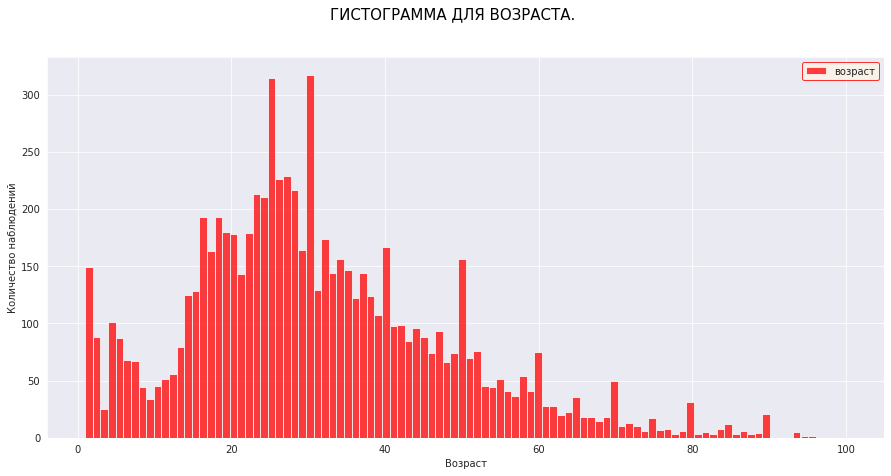

In [5]:
plt.figure(figsize=[15, 7])
plt.suptitle('ГИСТОГРАММА ДЛЯ ВОЗРАСТА.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=data['real_age'], color='r', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.show();

График распределения похож на нормальный. Большинство значений лежит в промежутке от 10 до 60.

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                      directory='/datasets/faces/final_files/',
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      seed = 12345)

Found 7591 validated image filenames.


In [7]:
features, target = next(train_datagen_flow)

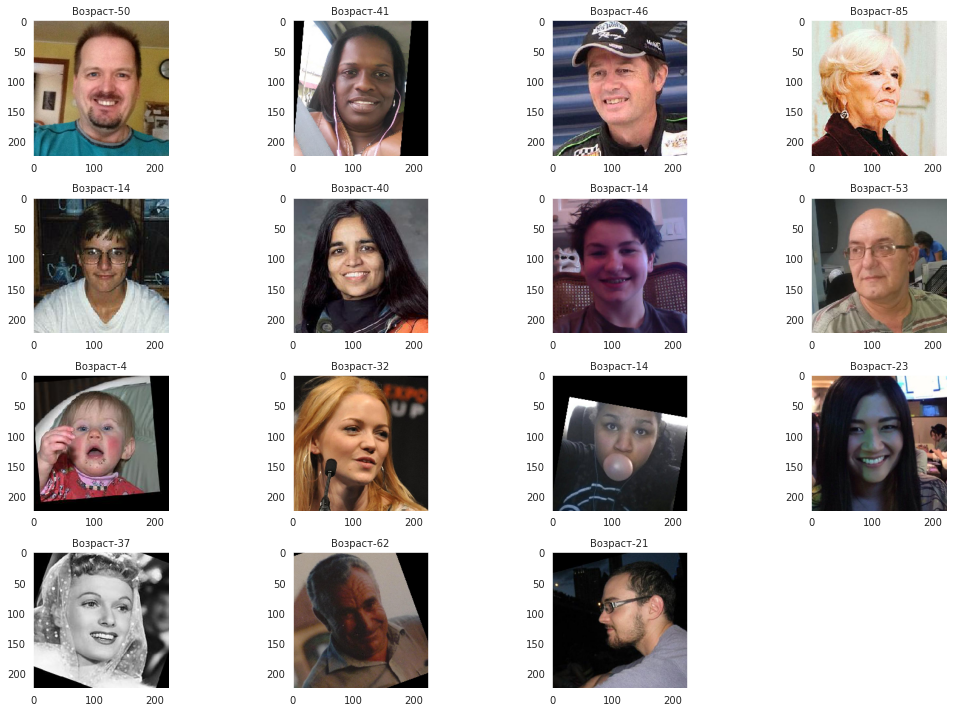

In [15]:
fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
plt.tight_layout()

In [16]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<b> В наборе данных присутствуют различные фотографии (черно-белые, цветные) людей разных полов и национальностей. Все данные впорядке.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

# Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-12-07 12:02:12.491665: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-07 12:02:13.665039: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 122s - loss: 235.4057 - mae: 11.0205 - val_loss: 725.3313 - val_mae: 21.9990
Epoch 2/10
178/178 - 92s - loss: 94.5536 - mae: 7.2827 - val_loss: 803.0053 - val_mae: 23.3499
Epoch 3/10
178/178 - 91s - loss: 71.7291 - mae: 6.4799 - val_loss: 269.4903 - val_mae: 12.1858
Epoch 4/10
178/178 - 91s - loss: 57.5173 - mae: 5.7709 - val_loss: 115.2836 - val_mae: 8.1052
Epoch 5/10
178/178 - 91s - loss: 49.7251 - mae: 5.4619 - val_loss: 91.3748 - val_mae: 7.1933
Epoch 6/10
178/178 - 91s - loss: 41.8055 - mae: 4.9879 - val_loss: 77.6141 - val_mae: 6.4827
Epoch 7/10
178/178 - 94s - loss: 36.9149 - mae: 4.6713 - val_loss: 76.4829 - val_mae: 6.3541
Epoch 8/10
178/178 - 91s - loss: 32.3881 - mae: 4.3970 - val_loss: 76.8647 - val_mae: 6.4344
Epoch 9/10
178/178 - 95s - loss: 27.9242 - mae: 4.0932 - val_loss: 81.1294 - val_mae: 6.8167
Epoch 10/10
178/178 - 91s - loss: 27.3676 - mae: 4.0249 - val_loss: 89.7072 - val_mae: 7.5239
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 89.7072 - mae: 7.5239


```

## Анализ обученной модели

<b> Я использовал модель на архитектуре RestNet50 с алгоритмом обучения Adam с частотой обучения lr=0.0001 (чем ниже шаг градиентного спуска, тем лучше подбираются параметры для нейронов). Колчество эпох равно 10.
    
   <br> Модель достигла нужного значения MAE=7.5239 < 8

<div style="border:solid Chocolate 2px; padding: 40px">
    
- Видеокурс от Stanford University: https://www.youtube.com/watch?v=vT1JzLTH4G4&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk
    
- Курс от Физтех-школы Прикладной Математики и Информатики МФТИ: https://vk.com/dlschool_mipt
    
- Курс Нейронные сети и компьютерное зрение от Sumsung: https://stepik.org/course/50352/promo#toc    
 